### Importing Necessary Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import os

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/GoogleDrive/')

Mounted at /content/GoogleDrive/


### Checking GPU Access

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading the Dataset

In [ ]:
train_ds, val_ds, test_ds = tfds.load(
                                      'mnist',
                                       split = ['train[:50000]', 'train[50000:]', 'test'],
                                       as_supervised = True
)

# Source: https://www.tensorflow.org/datasets/api_docs/python/tfds/load, https://www.tensorflow.org/datasets/splits

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
tf.data.experimental.cardinality(train_ds).numpy(), tf.data.experimental.cardinality(val_ds).numpy(), tf.data.experimental.cardinality(test_ds).numpy()

(50000, 10000, 10000)

### Checking Class Distribution

In [ ]:
def get_class_distribution(ds, num_classes):
  count = [0]*num_classes
  for item in ds:
    count[item[1].numpy()] += 1
  return count

In [ ]:
get_class_distribution(train_ds, 10) # relatively balanced

[4964, 5613, 4959, 5114, 4855, 4509, 4930, 5208, 4878, 4970]

In [ ]:
get_class_distribution(val_ds, 10) # relatively balanced as well

[959, 1129, 999, 1017, 987, 912, 988, 1057, 973, 979]

### Data Preprocessing

In [ ]:
def normalize(image, label):
  return tf.cast(image, tf.float32) / 255., label

def preprocess(ds, training = True):
  ds = ds.map(normalize, num_parallel_calls = tf.data.AUTOTUNE)
  if training:
    ds = ds.cache()
    ds = ds.shuffle(50000)
    ds = ds.batch(64)
    ds = ds.prefetch(tf.data.AUTOTUNE)
  else:
    ds = ds.batch(64)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

# Source: https://www.tensorflow.org/datasets/keras_example

In [ ]:
train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds, training = False)
test_ds = preprocess(test_ds, training = False)

### Creating the Model

In [ ]:
! pip install git+https://github.com/fversaci/WaveTF.git 

  Cloning https://github.com/fversaci/WaveTF.git to /tmp/pip-req-build-he7mg9g6
  Running command git clone -q https://github.com/fversaci/WaveTF.git /tmp/pip-req-build-he7mg9g6
  Created wheel for WaveTF: filename=WaveTF-0.1-py3-none-any.whl size=25282 sha256=4ab83dc9e099330dac31448bd7db4cfd9ce25364a918aee73dd235511e80bdf7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1sfen9dp/wheels/8e/ec/3d/1b322bbe7f99f023e33f5ae0fa6716e29abadde70a3ac6d299
Successfully built WaveTF


In [ ]:
from wavetf import WaveTFFactory

In [ ]:
class WaveletBlock(layers.Layer):
  def __init__(self, input_channels, wavelet, interpolation, **kwargs):
    super().__init__(**kwargs)
    self.input_channels = input_channels
    self.wavelet = wavelet
    self.interpolation = interpolation
    self.wavelet_transform = WaveTFFactory.build(wavelet)
    self.cA = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cH = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cV = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cD = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.concat = layers.Concatenate(axis = -1)
    self.linear = [layers.Conv2D(filters = input_channels, kernel_size = (1,1), strides = (1,1), padding = 'same'),
                   layers.BatchNormalization()
                  ]

  def call(self, inputs):
    z = self.wavelet_transform(inputs)

    cA = z[:,:,:,:self.input_channels]
    cV = z[:,:,:,self.input_channels:2*self.input_channels]
    cH = z[:,:,:,2*self.input_channels:3*self.input_channels]
    cD = z[:,:,:,3*self.input_channels:]

    for layer in self.cA:
      cA = layer(cA)
    for layer in self.cV:
      cV = layer(cV) 
    for layer in self.cH:
      cH = layer(cH) 
    for layer in self.cD:
      cD = layer(cD) 
    
    out = self.concat([cA,cV,cH,cD])

    for layer in self.linear:
      out = layer(out)
      
    return out + inputs

In [ ]:
def build_mnist_model(wavelet, interpolation):
  model = Sequential([layers.Input(shape = (28, 28, 1), name = 'input'),
                      layers.RandomRotation(factor = 10/360, name = 'random_rotation'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_1'),
                      layers.BatchNormalization(name = 'conv2d_1_bn'),
                      layers.Activation('relu', name = 'conv2d_1_relu'),
                      WaveletBlock(input_channels = 32, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_1'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_2'),
                      layers.BatchNormalization(name = 'conv2d_2_bn'),
                      layers.Activation('relu', name = 'conv2d_2_relu'),
                      WaveletBlock(input_channels = 64, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_2'),
                      layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_3'),
                      layers.BatchNormalization(name = 'conv2d_3_bn'),
                      layers.Activation('relu', name = 'conv2d_3_relu'),
                      layers.GlobalAveragePooling2D(name = 'avgpooling'),
                      layers.Dropout(0.4, name = 'dropout'),
                      layers.Dense(units = 10, activation = 'softmax', name = 'predictions')],
                     name = f'{wavelet}_{interpolation}_model')
  return model

In [ ]:
def train_model(model, wavelet, interpolation, initial_epoch = 0, epochs = 100):
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  dir_model = f'GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/{wavelet}_{interpolation}_mnist.h5'
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir_model, save_best_only = True, save_weights_only = True)
  with tf.device('/device:GPU:0'):
    history = model.fit(
                        x = train_ds,
                        initial_epoch = initial_epoch,
                        epochs = epochs, 
                        callbacks = [checkpoint_cb],
                        validation_data = val_ds
                        )
  return history

### Haar-Nearest

In [ ]:
haar_nearest = build_mnist_model('haar', 'nearest')

In [ ]:
haar_nearest_history = train_model(haar_nearest, 'haar', 'nearest')

Epoch 1/100
782/782 [==============================] - 47s 36ms/step - loss: 0.3916 - accuracy: 0.8943 - val_loss: 0.1216 - val_accuracy: 0.9642
Epoch 2/100
782/782 [==============================] - 27s 35ms/step - loss: 0.1292 - accuracy: 0.9640 - val_loss: 0.1040 - val_accuracy: 0.9700
Epoch 3/100
782/782 [==============================] - 27s 35ms/step - loss: 0.0956 - accuracy: 0.9726 - val_loss: 0.0706 - val_accuracy: 0.9797
Epoch 4/100
782/782 [==============================] - 28s 35ms/step - loss: 0.0816 - accuracy: 0.9765 - val_loss: 0.0609 - val_accuracy: 0.9808
Epoch 5/100
782/782 [==============================] - 28s 35ms/step - loss: 0.0731 - accuracy: 0.9786 - val_loss: 0.0499 - val_accuracy: 0.9846
Epoch 6/100
782/782 [==============================] - 28s 35ms/step - loss: 0.0673 - accuracy: 0.9797 - val_loss: 0.1296 - val_accuracy: 0.9612
Epoch 7/100
782/782 [==============================] - 28s 36ms/step - loss: 0.0606 - accuracy: 0.9818 - val_loss: 0.0434 - val_ac

In [ ]:
haar_nearest.evaluate(test_ds)

157/157 [==============================] - 2s 10ms/step - loss: 0.0344 - accuracy: 0.9909


[0.034438356757164, 0.9908999800682068]

In [ ]:
haar_nearest_saved = build_mnist_model('haar', 'nearest')
haar_nearest_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/haar_nearest_mnist.h5')
haar_nearest_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
haar_nearest_saved.evaluate(test_ds)

157/157 [==============================] - 2s 10ms/step - loss: 0.0268 - accuracy: 0.9932


[0.026787225157022476, 0.9932000041007996]

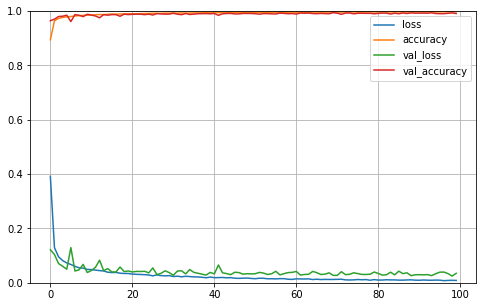

In [ ]:
pd.DataFrame(haar_nearest_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Haar-Bilinear

In [ ]:
haar_bilinear = build_mnist_model('haar', 'bilinear')

In [ ]:
haar_bilinear_history = train_model(haar_bilinear, 'haar', 'bilinear')

Epoch 1/100
782/782 [==============================] - 31s 36ms/step - loss: 0.3525 - accuracy: 0.9021 - val_loss: 0.1883 - val_accuracy: 0.9422
Epoch 2/100
782/782 [==============================] - 28s 36ms/step - loss: 0.1112 - accuracy: 0.9684 - val_loss: 0.1731 - val_accuracy: 0.9459
Epoch 3/100
782/782 [==============================] - 29s 36ms/step - loss: 0.0890 - accuracy: 0.9733 - val_loss: 0.0812 - val_accuracy: 0.9730
Epoch 4/100
782/782 [==============================] - 28s 36ms/step - loss: 0.0790 - accuracy: 0.9760 - val_loss: 0.0548 - val_accuracy: 0.9828
Epoch 5/100
782/782 [==============================] - 28s 36ms/step - loss: 0.0678 - accuracy: 0.9790 - val_loss: 0.0626 - val_accuracy: 0.9808
Epoch 6/100
782/782 [==============================] - 28s 36ms/step - loss: 0.0623 - accuracy: 0.9809 - val_loss: 0.0413 - val_accuracy: 0.9861
Epoch 7/100
782/782 [==============================] - 28s 36ms/step - loss: 0.0577 - accuracy: 0.9830 - val_loss: 0.0515 - val_ac

In [ ]:
haar_bilinear.evaluate(test_ds)

157/157 [==============================] - 2s 10ms/step - loss: 0.0255 - accuracy: 0.9923


[0.02545943297445774, 0.9922999739646912]

In [ ]:
haar_bilinear_saved = build_mnist_model('haar', 'bilinear')
haar_bilinear_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/haar_bilinear_mnist.h5')
haar_bilinear_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
haar_bilinear_saved.evaluate(test_ds)

157/157 [==============================] - 2s 10ms/step - loss: 0.0257 - accuracy: 0.9917


[0.025701485574245453, 0.9916999936103821]

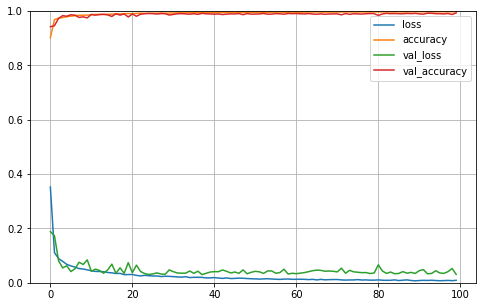

In [ ]:
pd.DataFrame(haar_bilinear_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### DB2-Nearest

In [ ]:
db2_nearest = build_mnist_model('db2', 'nearest')

In [ ]:
db2_nearest_history = train_model(db2_nearest, 'db2', 'nearest')

Epoch 1/100
782/782 [==============================] - 36s 42ms/step - loss: 0.3941 - accuracy: 0.8902 - val_loss: 0.2615 - val_accuracy: 0.9182
Epoch 2/100
782/782 [==============================] - 33s 42ms/step - loss: 0.1277 - accuracy: 0.9648 - val_loss: 0.1625 - val_accuracy: 0.9451
Epoch 3/100
782/782 [==============================] - 33s 42ms/step - loss: 0.0986 - accuracy: 0.9715 - val_loss: 0.1328 - val_accuracy: 0.9596
Epoch 4/100
782/782 [==============================] - 33s 42ms/step - loss: 0.0808 - accuracy: 0.9760 - val_loss: 0.1303 - val_accuracy: 0.9635
Epoch 5/100
782/782 [==============================] - 33s 42ms/step - loss: 0.0729 - accuracy: 0.9781 - val_loss: 0.0641 - val_accuracy: 0.9801
Epoch 6/100
782/782 [==============================] - 32s 41ms/step - loss: 0.0662 - accuracy: 0.9803 - val_loss: 0.0984 - val_accuracy: 0.9714
Epoch 7/100
782/782 [==============================] - 33s 41ms/step - loss: 0.0615 - accuracy: 0.9818 - val_loss: 0.0822 - val_ac

In [ ]:
db2_nearest.evaluate(test_ds)

157/157 [==============================] - 2s 11ms/step - loss: 0.0311 - accuracy: 0.9903


[0.031066711992025375, 0.9902999997138977]

In [ ]:
db2_nearest_saved = build_mnist_model('db2', 'nearest')
db2_nearest_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/db2_nearest_mnist.h5')
db2_nearest_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
db2_nearest_saved.evaluate(test_ds)

157/157 [==============================] - 3s 11ms/step - loss: 0.0321 - accuracy: 0.9912


[0.03210601583123207, 0.9911999702453613]

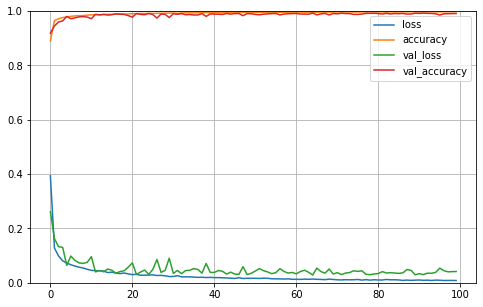

In [ ]:
pd.DataFrame(db2_nearest_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### DB2-Bilinear

In [ ]:
db2_bilinear = build_mnist_model('db2', 'bilinear')

In [ ]:
db2_bilinear_history = train_model(db2_bilinear, 'db2', 'bilinear')

Epoch 1/100
782/782 [==============================] - 36s 43ms/step - loss: 0.3586 - accuracy: 0.9029 - val_loss: 0.4272 - val_accuracy: 0.8595
Epoch 2/100
782/782 [==============================] - 33s 43ms/step - loss: 0.1202 - accuracy: 0.9658 - val_loss: 0.0953 - val_accuracy: 0.9704
Epoch 3/100
782/782 [==============================] - 33s 42ms/step - loss: 0.0941 - accuracy: 0.9724 - val_loss: 0.1729 - val_accuracy: 0.9429
Epoch 4/100
782/782 [==============================] - 33s 42ms/step - loss: 0.0807 - accuracy: 0.9760 - val_loss: 0.0715 - val_accuracy: 0.9771
Epoch 5/100
782/782 [==============================] - 33s 42ms/step - loss: 0.0699 - accuracy: 0.9788 - val_loss: 0.0941 - val_accuracy: 0.9719
Epoch 6/100
782/782 [==============================] - 33s 42ms/step - loss: 0.0653 - accuracy: 0.9808 - val_loss: 0.0541 - val_accuracy: 0.9832
Epoch 7/100
782/782 [==============================] - 33s 42ms/step - loss: 0.0593 - accuracy: 0.9815 - val_loss: 0.0735 - val_ac

In [ ]:
db2_bilinear.evaluate(test_ds)

157/157 [==============================] - 2s 11ms/step - loss: 0.0299 - accuracy: 0.9916


[0.029899517074227333, 0.991599977016449]

In [ ]:
db2_bilinear_saved = build_mnist_model('db2', 'bilinear')
db2_bilinear_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/db2_bilinear_mnist.h5')
db2_bilinear_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
db2_bilinear_saved.evaluate(test_ds)

157/157 [==============================] - 3s 11ms/step - loss: 0.0264 - accuracy: 0.9923


[0.026362432166934013, 0.9922999739646912]

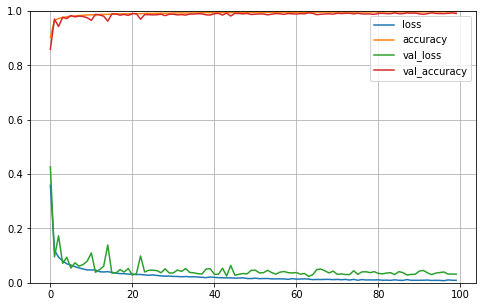

In [ ]:
pd.DataFrame(db2_bilinear_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Fully Conv

In [ ]:
fully_conv = Sequential([layers.Input(shape = (28, 28, 1), name = 'input'),
                      layers.RandomRotation(factor = 10/360, name = 'random_rotation'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_1'),
                      layers.BatchNormalization(name = 'conv2d_1_bn'),
                      layers.Activation('relu', name = 'conv2d_1_relu'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_2'),
                      layers.BatchNormalization(name = 'conv2d_2_bn'),
                      layers.Activation('relu', name = 'conv2d_2_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_3'),
                      layers.BatchNormalization(name = 'conv2d_3_bn'),
                      layers.Activation('relu', name = 'conv2d_3_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_4'),
                      layers.BatchNormalization(name = 'conv2d_4_bn'),
                      layers.Activation('relu', name = 'conv2d_4_relu'),
                      layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_5'),
                      layers.BatchNormalization(name = 'conv2d_5_bn'),
                      layers.Activation('relu', name = 'conv2d_5_relu'),
                      layers.GlobalAveragePooling2D(name = 'avgpooling'),
                      layers.Dropout(0.4, name = 'dropout'),
                      layers.Dense(units = 10, activation = 'softmax', name = 'predictions')],
                     name = f'fully_conv_model')

In [ ]:
fully_conv.summary()

Model: "fully_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 28, 28, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_2_bn (BatchNormaliza  (None, 28, 28, 32)  

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
fully_conv.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
dir_model = 'GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/fully_conv_mnist.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir_model, save_best_only = True)
with tf.device('/device:GPU:0'):
  fully_conv_history = fully_conv.fit(
                        x = train_ds,
                        epochs = 100, 
                        callbacks = [checkpoint_cb],
                        validation_data = val_ds
                        )

Epoch 1/100
782/782 [==============================] - 39s 24ms/step - loss: 0.3447 - accuracy: 0.9137 - val_loss: 0.4479 - val_accuracy: 0.8505
Epoch 2/100
782/782 [==============================] - 16s 20ms/step - loss: 0.0979 - accuracy: 0.9735 - val_loss: 0.0577 - val_accuracy: 0.9826
Epoch 3/100
782/782 [==============================] - 16s 20ms/step - loss: 0.0721 - accuracy: 0.9789 - val_loss: 0.0556 - val_accuracy: 0.9833
Epoch 4/100
782/782 [==============================] - 16s 20ms/step - loss: 0.0630 - accuracy: 0.9819 - val_loss: 0.0486 - val_accuracy: 0.9848
Epoch 5/100
782/782 [==============================] - 16s 20ms/step - loss: 0.0544 - accuracy: 0.9836 - val_loss: 0.0477 - val_accuracy: 0.9851
Epoch 6/100
782/782 [==============================] - 16s 20ms/step - loss: 0.0488 - accuracy: 0.9859 - val_loss: 0.0840 - val_accuracy: 0.9742
Epoch 7/100
782/782 [==============================] - 15s 19ms/step - loss: 0.0442 - accuracy: 0.9866 - val_loss: 0.0776 - val_ac

In [ ]:
fully_conv.evaluate(test_ds)

157/157 [==============================] - 2s 14ms/step - loss: 0.0271 - accuracy: 0.9933


[0.027128223329782486, 0.9933000206947327]

In [ ]:
fully_conv_saved = keras.models.load_model('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/fully_conv_mnist.h5')
fully_conv_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
fully_conv_saved.evaluate(test_ds)

157/157 [==============================] - 2s 8ms/step - loss: 0.0159 - accuracy: 0.9952


[0.015898151323199272, 0.995199978351593]

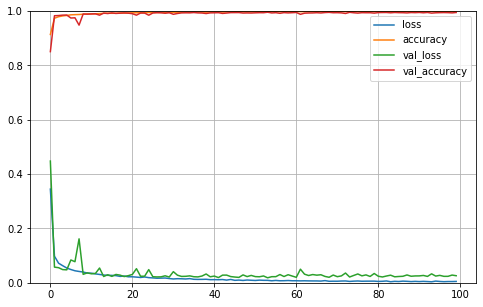

In [ ]:
pd.DataFrame(fully_conv_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()